In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget
sns.set_theme()

In [2]:
#wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv")

In [3]:
df = pd.read_csv("../data/laptops.csv")

In [4]:
# normalize the names of the columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
# choose columns to use

df = df[["ram", "storage", "screen", "final_price"]]

In [6]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


yes, the tail of the distribution graph is pretty long


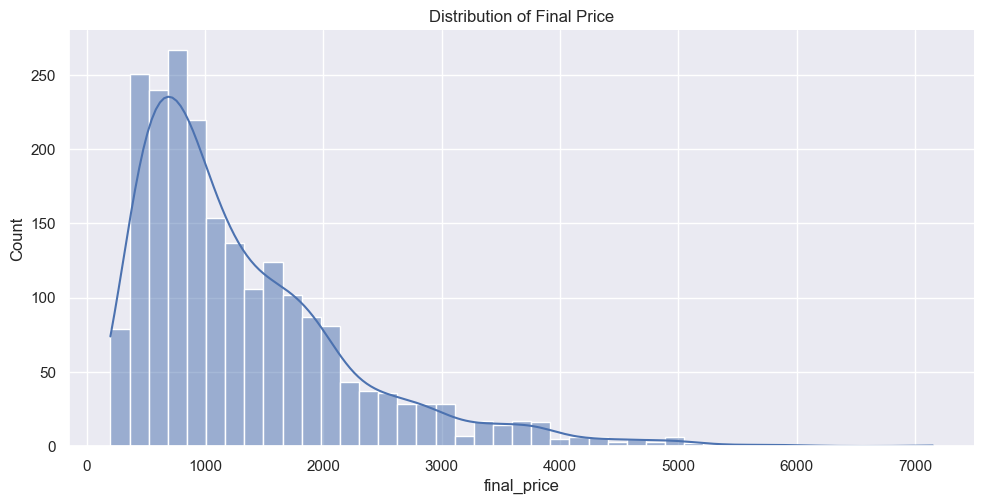

In [7]:
# look at the final_price variable. Does it have a long tail?  

sns.displot(data=df, x="final_price", kde=True, height=5, aspect=2)
plt.title("Distribution of Final Price")
print("yes, the tail of the distribution graph is pretty long")

### Question 1
There's one column with missing values. What is it?

In [8]:
df.isnull().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

"screen" - column with missing values

### Question 2
What's the median (50% percentile) for variable 'ram'?

In [9]:
print(f"Median value for variable 'ram': {df.median()["ram"]}")

Median value for variable 'ram': 16.0


### Prepare and split the dataset

Shuffle the dataset (the filtered one you created above), use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.


In [10]:
"""COPY FROM LECTURE NOTEBOOK
"""

n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
# set seed 
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Length of train, test and val: {len(df_train), len(df_test), len(df_val)}")

Length of train, test and val: (1296, 432, 432)


### Question 3

We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

Options:

With 0
With mean
Both are equally good


In [11]:
# create two datasets

# fill with zero. We can use fillna without specifying the column since only "screen" has missing values
df_train_zero = df_train.fillna(0)
df_test_zero = df_test.fillna(0)
df_val_zero = df_val.fillna(0)

# fill with mean
screen_mean = df_train.screen.mean()
df_train_mean = df_train.fillna(screen_mean)
df_test_mean = df_test.fillna(screen_mean)
df_val_mean = df_val.fillna(screen_mean)
print(f"Filled screen columns missing values with train mean of {screen_mean:.2f}")

Filled screen columns missing values with train mean of 15.16


In [12]:
"""COPY FROM LECTURE NOTEBOOK
"""

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [13]:
# train LR and make precitions using zero-filled df

X_train_zero, y_train_zero = df_train_zero[["ram", "storage", "screen"]].values, df_train_zero[["final_price"]].values
X_val_zero, y_val_zero = df_val_zero[["ram", "storage", "screen"]].values, df_val_zero[["final_price"]].values

# train model 
w0, w = train_linear_regression(X_train_zero, y_train_zero)

# make predictions
y_pred_zero = w0 + X_val_zero@w

# rmse 
rmse_zero = rmse(y_val_zero, y_pred_zero)
print(f"RMSE using zero-filling missing values: {rmse_zero:.2f}")

RMSE using zero-filling missing values: 597.36


In [14]:
# train LR and make precitions using mean-filled df

X_train_mean, y_train_mean = df_train_mean[["ram", "storage", "screen"]].values, df_train_mean[["final_price"]].values
X_val_mean, y_val_mean = df_val_mean[["ram", "storage", "screen"]].values, df_val_mean[["final_price"]].values

# train model 
w0, w = train_linear_regression(X_train_mean, y_train_mean)

# make predictions
y_pred_mean = w0 + X_val_mean@w

# rmse 
rmse_mean = rmse(y_val_mean, y_pred_mean)
print(f"RMSE using mean-filling missing values: {rmse_mean:.2f}")

RMSE using mean-filling missing values: 600.27


Since rmse using zero-filling gives smaller error this models gives better results

### Question 4
Now let's train a regularized linear regression.

For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].

Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?

If there are multiple options, select the smallest r.


In [15]:
"""COPY FROM LECTURE NOTEBOOK
"""
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [16]:
# use df filled with 0

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
evaluation = {}

for r in r_values: 
    # train model 
    w0, w = train_linear_regression_reg(X_train_zero, y_train_zero, r)

    # make predictions
    y_pred_zero = w0 + X_val_zero@w

    # rmse 
    rmse_zero = rmse(y_val_zero, y_pred_zero)

    evaluation[r] = float(round(rmse_zero, 2))

In [17]:
evaluation

{0: 597.36,
 0.01: 597.36,
 0.1: 597.35,
 1: 597.21,
 5: 597.01,
 10: 597.06,
 100: 597.9}

In [18]:
min(evaluation.items(), key=lambda x: evaluation[x[0]])

(5, 597.01)

We can see that r = 5 has the best rmse but in answers application form there is no such answer, so I choose 10 as the second best


### Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))

In [19]:
# seeds through which we will iterate
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

errors = np.ones(len(seeds))

for seed in seeds: 
    """ Do the same linear regression training as before
    """
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    df_train_zero = df_train.fillna(0)
    df_test_zero = df_test.fillna(0)
    df_val_zero = df_val.fillna(0)


    X_train_zero, y_train_zero = df_train_zero[["ram", "storage", "screen"]].values, df_train_zero[["final_price"]].values
    X_val_zero, y_val_zero = df_val_zero[["ram", "storage", "screen"]].values, df_val_zero[["final_price"]].values

    # train model 
    w0, w = train_linear_regression(X_train_zero, y_train_zero)

    # make predictions
    y_pred_zero = w0 + X_val_zero@w

    # rmse 
    rmse_zero = rmse(y_val_zero, y_pred_zero)

    errors[seed] = rmse_zero

print(f"Errors: {errors}")

Errors: [565.45208688 636.79854231 588.95586979 597.814892   571.96279151
 573.23832566 647.34383284 550.43981845 587.33350362 576.10179294]


In [20]:
# computing std

scores_std = np.std(errors)
print(f'Scores std: {scores_std:.3f}')

Scores std: 29.176


### Question 6

Split the dataset like previously, use seed 9.

Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [21]:
seed = 9 

idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train_zero = df_train.fillna(0)
df_test_zero = df_test.fillna(0)
df_val_zero = df_val.fillna(0)

X_train_zero, y_train_zero = df_train_zero[["ram", "storage", "screen"]].values, df_train_zero[["final_price"]].values
X_val_zero, y_val_zero = df_val_zero[["ram", "storage", "screen"]].values, df_val_zero[["final_price"]].values
X_test_zero, y_test_zero = df_test_zero[["ram", "storage", "screen"]].values, df_test_zero[["final_price"]].values

# combine train and val data 
X = np.concat([X_train_zero, X_val_zero])
y = np.concat([y_train_zero, y_val_zero])

# train model 
w0, w = train_linear_regression(X, y)

# make predictions
y_pred = w0 + X_test_zero@w

# rmse 
rmse_zero = rmse(y_test_zero, y_pred)

print(f'RMSE on test dataset: {rmse_zero}')

RMSE on test dataset: 608.6102791248078
